# Multi-Omics Analysis for SKCM Survival Prediction

Bla



## Imports and helper functions

In [1]:
import os
import datetime
import random
import functools
import typing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set_theme(style="darkgrid")
import lifelines
from tqdm.notebook import tqdm, trange

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold

In [2]:
import coxae
from coxae.model import CoxAutoencoderClustering, ConcreteCoxAutoencoderClustering
from coxae.utils import get_kmfs
from coxae.preprocessing import dict_of_dfs_to_df_list, merge_df_list, merge_dict_of_dfs, stack_dicts


In [3]:
# Set the random seeds
seed = 0
np.random.seed(seed)
random.seed(seed)

In [4]:
def plot_dim_reduction(
        df_or_dfs:typing.Union[dict, pd.DataFrame],
        df_clin:pd.DataFrame,
        dim_reduction = TSNE,
        dim_reduction_label = "TSNE_{}",
        ):
    n_components = 2
    df_features = (
        merge_df_list(dict_of_dfs_to_df_list(df_or_dfs))
        if isinstance(df_or_dfs, dict) else
        df_or_dfs
    )
    df_plot = pd.DataFrame(dim_reduction(n_components).fit_transform(df_features.values), index=df_features.index, columns=[dim_reduction_label.format(i) for i in range(n_components)])
    df_plot = df_plot.join(df_clin)
    sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="observed")
    plt.show()
    sns.scatterplot(data=df_plot[df_plot["observed"]==1], x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="duration")
    plt.show()
    df_plot

## Data Acquisition and Pre-Processing

### Acquiring data from the MAUI's paper study

In [5]:
data_directory = "./data/hierae_data/processed/SKCM/merged"

In [6]:
data = pd.read_csv(os.path.join(data_directory, 'new_clinical_multi_omics_with_rppa.csv'))

In [7]:
data.shape

(238, 85256)

In [8]:
data_no_na = data.dropna(axis="columns")
data_no_na.shape

(238, 85256)

In [9]:
survival = data[["OS","OS.time"]].rename(columns={"OS":"observed","OS.time":"duration"})
survival.head()

,observed,duration
0,0,486
1,0,2950
2,0,439
3,1,1154
4,0,210


See which omics layers are available in the dataset

In [10]:
set(col.split("_")[0] for col in data.columns)

{'OS',
 'OS.time',
 'clinical',
 'cnv',
 'gex',
 'meth',
 'mirna',
 'mutation',
 'rppa'}

Plot a Kaplan-Meier plot of the whole dataset to have better view of it

<AxesSubplot:xlabel='timeline'>

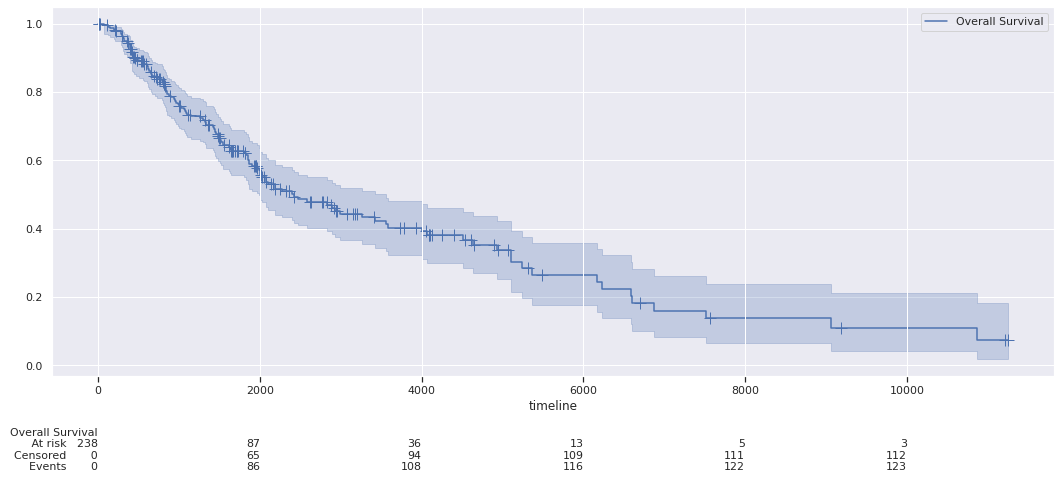

In [11]:
kmf = lifelines.KaplanMeierFitter(label="Overall Survival")
kmf.fit(durations=survival["duration"],
        event_observed=survival["observed"])
plt.figure(figsize=(15,7))
kmf.plot(show_censors=1, ci_show=1, at_risk_counts=True)

Check the maximum RNAseq count value in the dataset.

Get the datasets that will be used as features:

In [12]:
df_clin = survival
df_clinical_features = data_no_na[[col for col in data_no_na.columns if col.split("_")[0]=="clinical"]]
df_cnv = data_no_na[[col for col in data_no_na.columns if col.split("_")[0]=="cnv"]]
df_gex = data_no_na[[col for col in data_no_na.columns if col.split("_")[0]=="gex"]].apply(lambda x: np.log2(np.where(x<0,np.zeros_like(x),x)+1)) # Max between the value and x is taken due to some gene expression values being less than one for some reason
df_meth = data_no_na[[col for col in data_no_na.columns if col.split("_")[0]=="meth"]]
df_mirna = data_no_na[[col for col in data_no_na.columns if col.split("_")[0]=="mirna"]].apply(lambda x: np.log2(np.where(x<0,np.zeros_like(x),x)+1))
df_mutation = data_no_na[[col for col in data_no_na.columns if col.split("_")[0]=="mutation"]]
df_rppa = data_no_na[[col for col in data_no_na.columns if col.split("_")[0]=="rppa"]]

feature_dfs = {
    "clin": df_clinical_features,
    "cnv": df_cnv,
    "gex": df_gex,
    "meth": df_meth,
    "mirna": df_mirna,
    "mut": df_mutation,
    "rppa": df_rppa
}

Get the input dataset:

In [13]:
X = {k:feature_dfs[k].values for k in feature_dfs}
durations = df_clin["duration"].values
events = df_clin["observed"].values

Plot a reduced dimensionality view of the dataset:

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


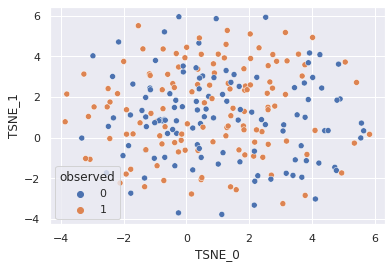

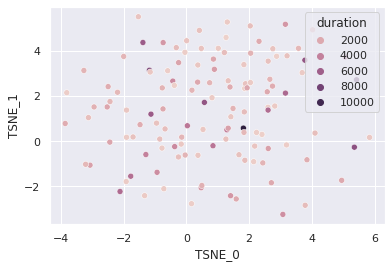

In [14]:
plot_dim_reduction(merge_dict_of_dfs(feature_dfs), df_clin)

## Use the model to analyse the data

In [15]:
model = ConcreteCoxAutoencoderClustering(encoding_feature_selector=coxae.feature_selection.CoxPHFeatureSelector(limit_significant=20, get_most_significant_combination_time_limit=0))
model.fit({k:X[k] for k in X}, durations, events)

In [16]:
clusters = model.cluster(X)
hazards = model.hazard(X)
_, p_value = model.logrank_p_score(clusters, durations, events)
c_index = model.concordance_index(hazards, durations, events)
p_value, c_index

(1.4111048132390944e-07, 0.708248601931876)

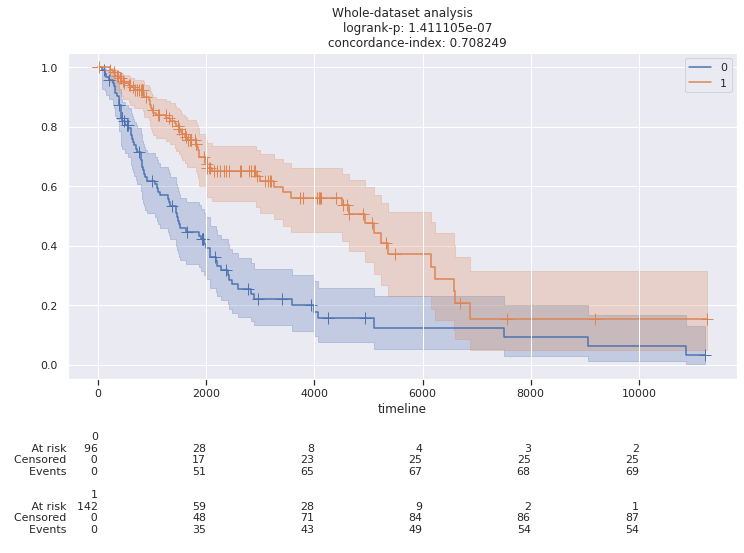

In [17]:
plt.figure(figsize=(12,6))
if not np.isnan(p_value):
    ax = plt.gca()
    kmfs, _ = get_kmfs(clusters, durations, events)
    for kmf in kmfs:
        kmf.plot(show_censors=1, ci_show=1, ax=ax)
    lifelines.plotting.add_at_risk_counts(*kmfs, ax=ax)
    plt.title(
        """Whole-dataset analysis
        logrank-p: {p_value:.6e}
        concordance-index: {c_index:.6f}""".format(
            p_value=p_value,
            c_index=c_index,
        )
    )
    for fmt in ["png", "pdf"]:
        plt.savefig("whole-dset-{model}-{date}.{fmt}".format(model=type(model).__name__, date=datetime.date.today(),fmt=fmt), bbox_inches="tight")


In [18]:
topk_feature_idxs = {
    layer: np.argsort(model.input_feature_selectors[layer].selector.scores_)[:model.input_feature_selectors[layer].selector.k]
    for layer in model.input_feature_selectors
}
topk_feature_dfs = {
    layer: feature_dfs[layer].iloc[:,topk_feature_idxs[layer]]
    for layer in feature_dfs
}
df_ae_input = merge_dict_of_dfs(topk_feature_dfs)

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


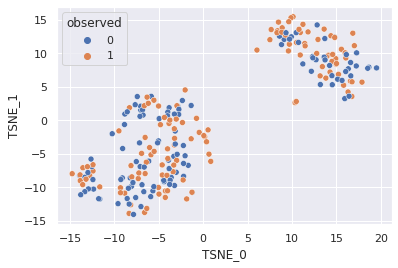

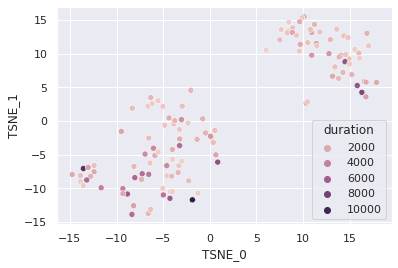

In [19]:
plot_dim_reduction(df_ae_input, df_clin)

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


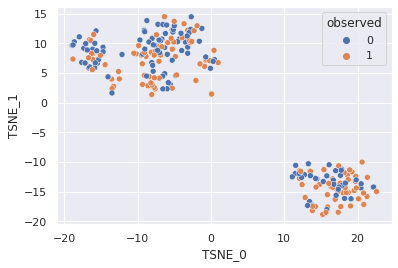

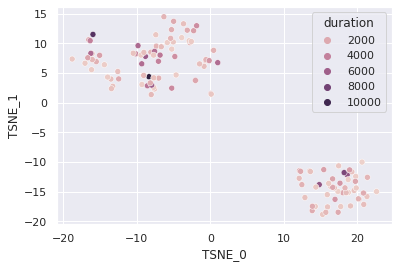

In [38]:
plot_dim_reduction(pd.DataFrame(model._ConcreteCoxAutoencoderClustering__integrate(df_ae_input.values)), df_clin)

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


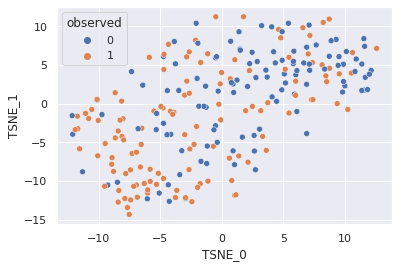

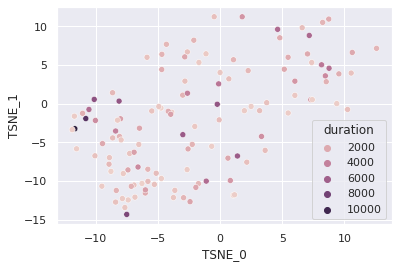

In [39]:
plot_dim_reduction(pd.DataFrame(model.integrate(X)), df_clin)

In [20]:
for df, name in zip([merge_dict_of_dfs(feature_dfs),df_ae_input.copy()],["all","ae_input"]):
    df["clusters"] = clusters
    df.to_csv("{model}_{name}.csv".format(model=type(model).__name__, name=name))

In [21]:
concrete_ae_selected_feature_idxs = model.ae.get_selected_feature_indexes()
df_ae_fingerprints = df_ae_input.iloc[:,concrete_ae_selected_feature_idxs]

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


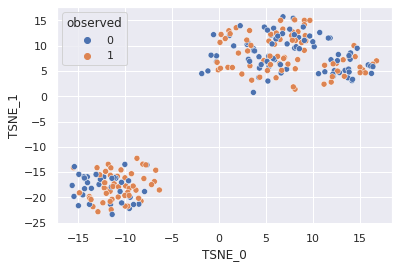

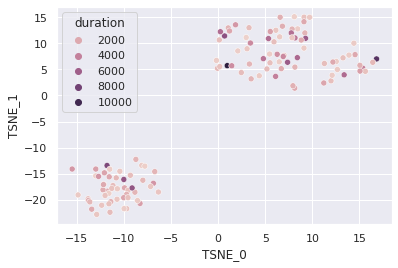

In [22]:
plot_dim_reduction(df_ae_fingerprints, df_clin)

In [23]:
df_ae_fingerprints.describe()

,rppa_AKT,mutation_COTL1,gex_RUFY1|80230,mirna_hsa-miR-150-5p,mirna_hsa-miR-130b-3p,gex_TLN1|7094,mutation_TFF2,mirna_hsa-miR-552-5p,meth_cg13283942,mirna_hsa-miR-890,...,gex_WRNIP1|56897,mirna_hsa-miR-29c-5p,mutation_GMFB,meth_cg25999486,mirna_hsa-miR-628-5p,cnv_CCSER2,mirna_hsa-miR-372-5p,meth_cg07819926,mutation_LIN7C,meth_cg07819926
count,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,...,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000
mean,2.020868,0.004202,3.437560,3.426379,2.650221,3.849414,0.004202,0.142068,0.015692,0.002630,...,3.521025,2.433938,0.004202,0.019087,2.282356,-0.621849,0.003439,0.014275,0.004202,0.014275
std,0.603733,0.064820,0.056766,0.346155,0.229437,0.057420,0.064820,0.283766,0.002482,0.031315,...,0.060213,0.290682,0.064820,0.003100,0.276666,0.527579,0.053060,0.004087,0.064820,0.004087
min,-1.206054,0.000000,3.247499,2.208869,1.668538,3.680714,0.000000,0.000000,0.010759,0.000000,...,3.377616,1.256391,0.000000,0.013245,1.332501,-1.000000,0.000000,0.007524,0.000000,0.007524
25%,1.644599,0.000000,3.403548,3.256105,2.527343,3.815042,0.000000,0.000000,0.014035,0.000000,...,3.476880,2.265167,0.000000,0.016951,2.087017,-1.000000,0.000000,0.011465,0.000000,0.011465
50%,2.054194,0.000000,3.443720,3.484172,2.672293,3.846987,0.000000,0.000000,0.015408,0.000000,...,3.524059,2.457204,0.000000,0.018729,2.314878,-1.000000,0.000000,0.013446,0.000000,0.013446
75%,2.376340,0.000000,3.472746,3.650473,2.801633,3.883646,0.000000,0.202413,0.017137,0.000000,...,3.563692,2.619003,0.000000,0.020863,2.466457,0.000000,0.000000,0.016245,0.000000,0.016245
max,3.713154,1.000000,3.620160,4.162153,3.138268,4.065480,1.000000,1.354851,0.023078,0.451129,...,3.714090,3.261424,1.000000,0.031369,3.006750,2.000000,0.818576,0.036538,1.000000,0.036538


In [24]:
df_ae_fingerprints.columns.tolist()

['rppa_AKT',
 'mutation_COTL1',
 'gex_RUFY1|80230',
 'mirna_hsa-miR-150-5p',
 'mirna_hsa-miR-130b-3p',
 'gex_TLN1|7094',
 'mutation_TFF2',
 'mirna_hsa-miR-552-5p',
 'meth_cg13283942',
 'mirna_hsa-miR-890',
 'meth_cg12508214',
 'gex_CALM2|805',
 'mirna_hsa-miR-193b-3p',
 'mirna_hsa-miR-339-3p',
 'meth_cg04496615',
 'clinical_gender_FEMALE',
 'gex_PRPF6|24148',
 'meth_cg22870256',
 'meth_cg05432118',
 'mirna_hsa-miR-520f-5p',
 'cnv_LAMA5',
 'mirna_hsa-miR-627-5p',
 'mirna_hsa-miR-7-1-3p',
 'meth_cg18540305',
 'gex_SCARNA4|677771',
 'meth_cg25026013',
 'cnv_MIR5700',
 'gex_DEFB116|245930',
 'cnv_UNC5B',
 'cnv_SNORA40|ENSG00000264043.2',
 'mutation_TRDV2',
 'mirna_hsa-miR-302a-5p',
 'gex_CAPRIN1|4076',
 'mirna_hsa-miR-890',
 'mutation_MARCH5',
 'meth_cg25937494',
 'gex_ARFGAP2|84364',
 'cnv_SLIT1',
 'cnv_U4|ENSG00000272160.1',
 'meth_cg17189058',
 'meth_cg10442358',
 'mirna_hsa-miR-126-3p',
 'meth_cg06615861',
 'meth_cg06593568',
 'gex_USP5|8078',
 'cnv_RPS24',
 'mirna_hsa-miR-1',
 'mirna_

In [25]:
n_runs = 32
results = []
selected_feature_sets = []
significant_feature_sets = []
sets_absolute_neural_path_weights = []
significant_feature_indexes = []
for i in range(n_runs):
    model = ConcreteCoxAutoencoderClustering(encoding_feature_selector=coxae.feature_selection.CoxPHFeatureSelector(limit_significant=20, get_most_significant_combination_time_limit=0))
    model.fit({k:X[k] for k in X}, durations, events)
    
    clusters = model.cluster(X)
    hazards = model.hazard(X)
    _, p_value = model.logrank_p_score(clusters, durations, events)
    c_index = model.concordance_index(hazards, durations, events)

    plt.figure(figsize=(12,6))
    if not np.isnan(p_value):
        ax = plt.gca()
        kmfs, _ = get_kmfs(clusters, durations, events)
        for kmf in kmfs:
            kmf.plot(show_censors=1, ci_show=1, ax=ax)
        lifelines.plotting.add_at_risk_counts(*kmfs, ax=ax)
        plt.title(
            """Whole-dataset analysis
            logrank-p: {p_value:.6e}
            concordance-index: {c_index:.6f}""".format(
                p_value=p_value,
                c_index=c_index,
            )
        )
        for fmt in ["png", "pdf"]:
            plt.savefig("repetition-dset-{model}-{date}-{rep}.{fmt}".format(model=type(model).__name__, date=datetime.date.today(),fmt=fmt, rep=i), bbox_inches="tight")
        plt.close()

    topk_feature_idxs = {
        layer: np.argsort(model.input_feature_selectors[layer].selector.scores_)[:model.input_feature_selectors[layer].selector.k]
        for layer in model.input_feature_selectors
    }
    topk_feature_scores = {
        layer: model.input_feature_selectors[layer].selector.scores_[np.argsort(model.input_feature_selectors[layer].selector.scores_)[:model.input_feature_selectors[layer].selector.k]]
        for layer in model.input_feature_selectors
    }
    topk_feature_dfs = {
        layer: feature_dfs[layer].iloc[:,topk_feature_idxs[layer]]
        for layer in feature_dfs
    }
    df_ae_input = merge_dict_of_dfs(topk_feature_dfs)
    selected_feature_sets.append(set(df_ae_input.columns.tolist()))
    ae_input_scores = np.concatenate([topk_feature_scores[k] for k in sorted(topk_feature_scores)])

    concrete_ae_selected_feature_idxs = model.ae.ae.get_selected_feature_indexes()
    #ae_importance_matrix = model.ae.ae.get_feature_importance_matrix()
    #ae_selected_importance = ae_importance_matrix[concrete_ae_selected_feature_idxs,:]

    df_ae_fingerprints = df_ae_input.iloc[:,concrete_ae_selected_feature_idxs]
    most_important_features = df_ae_fingerprints.columns.tolist()
    
    significant_feature_sets.append(set(most_important_features))
    #sets_absolute_neural_path_weights.append(np.stack([feature_importance_matrix[most_important_features_ordering[:,i],i] for i in range(feature_importance_matrix.shape[1])], axis=1))
    #sets_absolute_neural_path_weights.append(np.stack([feature_importance_matrix[most_important_features_ordering[:,i],i] for i in range(feature_importance_matrix.shape[1])], axis=1))
    #significant_feature_indexes.append(most_important_features_ordering)

In [26]:
robust_significant_feature_sets = functools.reduce(set.intersection, significant_feature_sets, functools.reduce(set.union, significant_feature_sets, set()))
len(robust_significant_feature_sets)

0

In [27]:
df_features = pd.DataFrame(
    data={
        "feature": [feature for features in significant_feature_sets for feature in features],
        "layer": [feature.split("_")[0] for features in significant_feature_sets for feature in features],
        "repetition": [1+i for i, features in enumerate(significant_feature_sets) for feature in features],
    }
)
df_feature_count = df_features.groupby("feature").count()
df_feature_count = df_feature_count.drop(columns=["repetition"])
df_feature_count = df_feature_count.rename(columns={"layer":"count"}).sort_values("count", ascending=False).reset_index()
df_feature_count["percentage"] = df_feature_count["count"]/n_runs
df_feature_count["layer"] = df_feature_count["feature"].str.split("_").str[0]

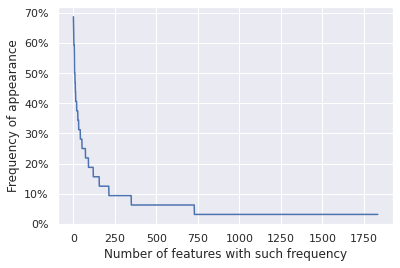

In [28]:
(df_feature_count["percentage"]*100).plot()
ax = plt.gca()
ax.yaxis.set_major_formatter( mtick.PercentFormatter())
plt.ylabel("Frequency of appearance")
plt.xlabel("Number of features with such frequency")
for fmt in ["png", "pdf"]:
    plt.savefig("repetition-freqcurve-{model}-{date}.{fmt}".format(model=type(model).__name__, date=datetime.date.today(),fmt=fmt), bbox_inches="tight")

0.125 214 ['clinical_gender_FEMALE', 'gex_CNBP|7555', 'meth_cg18485154', 'gex_ZNF410|57862', 'meth_cg07819926', 'mirna_hsa-miR-1277-3p', 'gex_ARFGAP2|84364', 'mirna_hsa-miR-627-5p', 'meth_cg01755369', 'meth_cg10294797', 'mirna_hsa-miR-520f-5p', 'meth_cg20225889', 'gex_PRDM4|11108', 'meth_cg05348272', 'meth_cg02441831', 'meth_cg25026013', 'gex_C20orf11|54994', 'gex_RAD23B|5887', 'meth_cg06188683', 'rppa_FASN', 'gex_CALM2|805', 'gex_NONO|4841', 'gex_SEC31A|22872', 'meth_cg16286776', 'meth_cg18337803', 'gex_AP3M1|26985', 'meth_cg26863324', 'meth_cg05526376', 'meth_cg20337385', 'gex_VN1R4|317703', 'gex_WASF2|10163', 'gex_AAGAB|79719', 'gex_OR4S2|219431', 'gex_MAX|4149', 'gex_TAS2R41|259287', 'gex_CST8|10047', 'rppa_PKCDELTA_pS664', 'gex_CHD8|57680', 'rppa_HEREGULIN', 'gex_SAFB2|9667', 'mirna_hsa-miR-29c-5p', 'rppa_RBM15', 'mirna_hsa-miR-616-5p', 'gex_PAK2|5062', 'meth_cg10442358', 'gex_ATP5A1|498', 'mirna_hsa-miR-150-5p', 'meth_cg17714828', 'rppa_EGFR', 'gex_HSPA8|3312', 'meth_cg25241845',

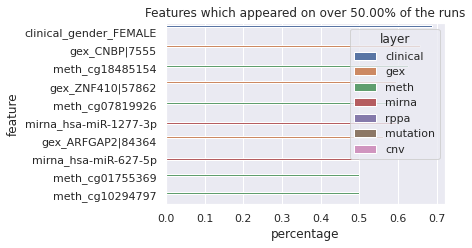

In [29]:
for pct in [0.125, 0.25, 0.5]:
    plt.close()
    most_common_features = df_feature_count[df_feature_count["percentage"]>=pct]["feature"]
    print(pct, len(most_common_features.tolist()), most_common_features.tolist())
    fig = plt.figure(figsize=(5,len(most_common_features.tolist())/3))
    ax = plt.gca()
    sns.barplot(data=df_feature_count.reset_index(), x="percentage", y="feature", hue="layer", ax=ax, order=most_common_features)
    plt.title("Features which appeared on over {:.2%} of the runs".format(pct))
    for fmt in ["png", "pdf"]:
        plt.savefig("repetition-{model}-{date}-{pct}.{fmt}".format(model=type(model).__name__, date=datetime.date.today(), pct=pct, fmt=fmt), bbox_inches="tight")

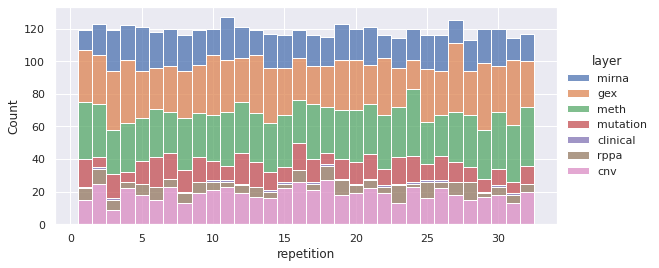

In [30]:
fig = plt.figure(figsize=(9,4))
ax = plt.gca()
sns.histplot(data=df_features, stat="count", x="repetition", hue="layer", multiple="stack", discrete=True, ax=ax)
sns.move_legend(
    ax, "center right",
    bbox_to_anchor=(1.2, 0.5),
    frameon=False,
)
for fmt in ["png", "pdf"]:
        plt.savefig("repetition-layer-counts-{model}-{date}.{fmt}".format(model=type(model).__name__, date=datetime.date.today(), fmt=fmt), bbox_inches="tight")

In [31]:
LABEL_N_FEAT = "Number of features selected"
LABEL_P_FEAT = "Percentage of layer features selected"
data_df = df_features.groupby(["layer","repetition"])["feature"].count().reset_index().rename(columns={"feature":LABEL_N_FEAT})

all_layers = data_df["layer"].unique()
for rep in data_df["repetition"].unique():
    layers_in_this_repetition = data_df[data_df["repetition"]==rep]["layer"].unique()
    missing_layers = list(set(all_layers) - set(layers_in_this_repetition))
    missing_values_df = pd.DataFrame(
        {
            "layer":missing_layers,
            "repetition":[rep]*len(missing_layers),
            LABEL_N_FEAT:[0]*len(missing_layers)
        }
    )
    data_df = pd.concat([data_df,missing_values_df], ignore_index=True)

data_df[LABEL_P_FEAT] = data_df[LABEL_N_FEAT]
feature_df_to_plot_layer_mapping = {
    "clin": "clinical",
    "cnv": "cnv",
    "gex": "gex",
    "meth": "meth",
    "mirna": "mirna",
    "mut": "mutation",
    "rppa": "rppa",
}
for feature_df_layer in topk_feature_dfs:
    print(feature_df_layer, len(topk_feature_dfs[feature_df_layer].columns))
    data_df_layer = feature_df_to_plot_layer_mapping[feature_df_layer]
    data_df.loc[data_df["layer"]==data_df_layer, LABEL_P_FEAT] = data_df[data_df["layer"]==data_df_layer][LABEL_N_FEAT] / len(topk_feature_dfs[feature_df_layer].columns)



clin 3
cnv 1000
gex 1000
meth 1000
mirna 741
mut 1000
rppa 189


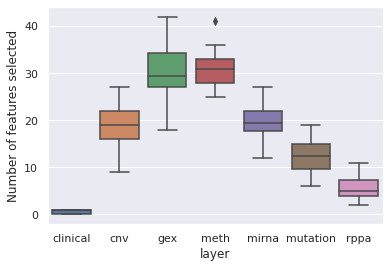

In [32]:
#fig = plt.figure(figsize=(9,4))
ax = plt.gca()
sns.boxplot(data=data_df, x="layer", y=LABEL_N_FEAT, ax=ax)
for fmt in ["png", "pdf"]:
        plt.savefig("layer-counts-distr-{model}-{date}.{fmt}".format(model=type(model).__name__, date=datetime.date.today(), fmt=fmt), bbox_inches="tight")

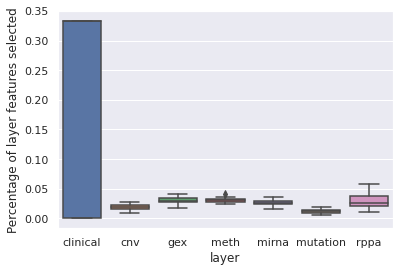

In [33]:
#fig = plt.figure(figsize=(9,4))
ax = plt.gca()
sns.boxplot(data=data_df, x="layer", y=LABEL_P_FEAT, ax=ax)
for fmt in ["png", "pdf"]:
        plt.savefig("layer-pct-distr-{model}-{date}.{fmt}".format(model=type(model).__name__, date=datetime.date.today(), fmt=fmt), bbox_inches="tight")

In [34]:
data_df.groupby("layer")[[LABEL_N_FEAT, LABEL_P_FEAT]].describe()

Number of features selected                                         \
                               count      mean       std   min    25%   50%   
layer                                                                         
clinical                        32.0   0.68750  0.470929   0.0   0.00   1.0   
cnv                             32.0  18.87500  4.125061   9.0  16.00  19.0   
gex                             32.0  30.46875  5.645348  18.0  27.00  29.5   
meth                            32.0  30.78125  3.589720  25.0  28.00  31.0   
mirna                           32.0  19.62500  3.643377  12.0  17.75  19.5   
mutation                        32.0  12.40625  3.644345   6.0   9.75  12.5   
rppa                            32.0   5.96875  2.429448   2.0   4.00   5.0   

                      Percentage of layer features selected            \
            75%   max                                 count      mean   
layer                                                                   
clinical   1.00   1.0                                  32.0  0.229167   
cnv       22.00  27.0                                  32.0  0.018875   
gex       34.25  42.0                                  32.0  0.030469   
meth      33.00  41.0                                  32.0  0.030781   
mirna     22.00  27.0                                  32.0  0.026484   
mutation  15.00  19.0                                  32.0  0.012406   
rppa       7.25  11.0                                  32.0  0.031581   

                                                                      
               std       min       25%       50%       75%       max  
layer                                                                 
clinical  0.156976  0.000000  0.000000  0.333333  0.333333  0.333333  
cnv       0.004125  0.009000  0.016000  0.019000  0.022000  0.027000  
gex       0.005645  0.018000  0.027000  0.029500  0.034250  0.042000  
meth      0.003590  0.025000  0.028000  0.031000  0.033000  0.041000  
mirna     0.004917  0.016194  0.023954  0.026316  0.029690  0.036437  
mutation  0.003644  0.006000  0.009750  0.012500  0.015000  0.019000  
rppa      0.012854  0.010582  0.021164  0.026455  0.038360  0.058201